In [169]:
import json
with open("config.json") as f:
    config = json.load(f)
cov_path = config["cov_path"]
map_2_emu_path = config["map_2_emu_path"]
map_3_emu_path = config["map_3_emu_path"]
save_file_path = config["save_file_path"]
main_path = config["main_path"]


In [ ]:
import sys
sys.path.append(main_path)
print(os.getcwd())

# Load all modules
import emulator_3pt

from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy.linalg import inv
import gdown
from nautilus import Prior
from nautilus import Sampler
import emcee
import os
import jax.numpy as jnp

/mnt/c/Users/Akshay/Documents/Project_work/MCMC_project/sampler_comparison-main/sampler_comparison-main
/mnt/c/Users/Akshay/Documents/Project_work/MCMC_project/sampler_comparison-main/sampler_comparison-main


In [ ]:
# Load the precomputed covariance matrix (shape: 40 x 40)
cov = np.load(cov_path)

# Dimensions
ns = 570 # number of simulations
nd = 40
ndim = 8

# Hartlap correction-inspired term
B = (ns - nd - 2) / ((ns - nd - 1) * (ns - nd - 4))
m = ndim + 2 + (ns - 1 + B * (nd - ndim)) / (1 + B * (nd - ndim))

# Inverse covariance
inv_cov = inv(cov)


In [ ]:
# Define log prior function
def log_prior(theta):
    Omega_m, sigma8, Omega_b, M1_z0_cen, M_c, beta, eta, theta_inn = theta

    if 0.23008603805291986 < Omega_m < 0.39969071100893877 and 0.7300666536240268 < sigma8 < 0.8999825383034264 \
        and 0.04000982924130305 < Omega_b < 0.059994733919925755 and 9.000497821926116 < M1_z0_cen < 12.997892823056496 \
        and 10.009180624129629 < M_c < 15.99716430647626 and -0.9967784660541272 < beta < 0.6992383181501483 \
        and -0.6977833279473113 < eta < 0.1991947243758576 and -1.9998000600318366 < theta_inn < -0.00020501523840121827:
        return 0
    return -np.inf

In [ ]:
# --- Step 3: Restore pretrained emulator for the Map23 statistic ---
Map2_emu = emulator_3pt.cosmoemu_jax(filepath=map_2_emu_path)
Map3_emu = emulator_3pt.cosmoemu_jax(filepath=map_3_emu_path)


priors_params = { 
                'Omega_m': [0.23008603805291986, 0.39969071100893877],
                'sigma8': [0.7300666536240268, 0.8999825383034264],
                'Omega_b': [0.04000982924130305, 0.059994733919925755],
                'M1_z0_cen': [9.000497821926116, 12.997892823056496], 
                'M_c': [10.009180624129629, 15.99716430647626], 
                'beta': [-0.9967784660541272, 0.6992383181501483], 
                'eta': [-0.6977833279473113, 0.1991947243758576], 
                'theta_inn': [-1.9998000600318366, -0.00020501523840121827],
            }

# names = ['Omega_m', 'sigma8', 'Omega_b', 'M1_z0_cen', 'M_c', 'beta', 'eta', 'theta_inn']

para_names_varying = list(priors_params.keys())
# print(para_names_varying)
param_dict_emu_true = {name: jnp.asarray([priors_params[name][1]/2+priors_params[name][0]/2], dtype=jnp.float32) for name in para_names_varying}

Map2_model = Map2_emu.ten_to_rescaled_predict(param_dict_emu_true)
Map3_model = Map3_emu.ten_to_rescaled_predict(param_dict_emu_true)
data = np.concatenate((Map2_model, Map3_model))
data.shape


/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/Map2_emu_converted.npz
KeysView(NpzFile '/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/Map2_emu_converted.npz' with keys: n_parameters, parameters, feature_dimensions, scaling_division, scaling_subtraction...)
/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/Map3_emu_nell64_nphi512_converted.npz
KeysView(NpzFile '/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/Map3_emu_nell64_nphi512_converted.npz' with keys: n_parameters, parameters, feature_dimensions, scaling_division, scaling_subtraction...)


(40,)

In [ ]:
# --- Step 4: Define the log-likelihood function using emulator predictions ---
def log_likelihood(param_dict):
    
    # Get the parameters   
    param_dict_emu = {name: jnp.asarray([param_dict[name]], dtype=jnp.float32) for name in para_names_varying}
    
    # Get model prediction
    Map2_model = Map2_emu.ten_to_rescaled_predict(param_dict_emu)
    Map3_model = Map3_emu.ten_to_rescaled_predict(param_dict_emu)
    model = jnp.concatenate((Map2_model, Map3_model))
    
    delta = data-model
    chi2 = np.matmul(delta,np.matmul(inv_cov,delta))
    likelihood = - 0.5 * m * np.log(1 + chi2 / (ns - 1.))
    return likelihood

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    # Convert array to dictionary
    param_dict = dict(zip(para_names_varying, theta))
    return lp + log_likelihood(param_dict)


In [159]:
import emcee
import numpy as np

# Number of walkers
nwalkers = 50
# Initial positions of walkers
p0 = []
for name in priors_params:
    low = priors_params[name][0]
    high = priors_params[name][1]
    p0.append(np.random.uniform(low, high, size=nwalkers))
p0 = np.array(p0).T

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# Number of steps
nsteps = 5000

# Run MCMC
sampler.run_mcmc(p0, nsteps, progress=True)


100%|███████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 69.25it/s]


State([[ 3.26427154e-01  7.91002048e-01  5.46557796e-02  1.24718357e+01
   1.34329207e+01  1.46379948e-01 -2.24737743e-01 -7.76634589e-01]
 [ 3.09467219e-01  8.24934038e-01  4.46012006e-02  1.22625029e+01
   1.36682590e+01  1.46296215e-01  8.49104886e-02 -6.32207354e-01]
 [ 3.32701301e-01  7.96172967e-01  5.75128804e-02  9.76694122e+00
   1.29058558e+01 -2.33090060e-01 -4.37483994e-02 -1.20825500e+00]
 [ 3.10024678e-01  8.17707603e-01  4.19081686e-02  1.05390401e+01
   1.28283191e+01 -2.56546130e-01 -3.04238120e-01 -8.04811729e-01]
 [ 3.15773640e-01  8.17845928e-01  4.82007718e-02  9.80012260e+00
   1.31834334e+01 -2.10685554e-01  1.36816051e-01 -1.04179024e+00]
 [ 3.05261431e-01  8.23392304e-01  4.21571860e-02  1.06325890e+01
   1.16899629e+01 -7.67690293e-01  1.77501227e-01 -1.25800040e+00]
 [ 3.02063352e-01  8.39792298e-01  4.75335179e-02  1.01923071e+01
   1.22241190e+01 -6.50632225e-01  5.03745705e-02 -1.19885177e+00]
 [ 3.08822725e-01  8.22218205e-01  4.82142863e-02  1.04787415e+

In [ ]:
# Save the samples
flat_samples = sampler.get_chain(discard=30, thin=15, flat=True)

from pathlib import Path

path = Path(save_file_path)
new_save_path = path.with_suffix("")
print(new_save_path) 

np.savez(str(new_save_path), samples=flat_samples, para_names_varying=para_names_varying)

/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/mcmc_samples


Text(0.5, 0, 'step number')

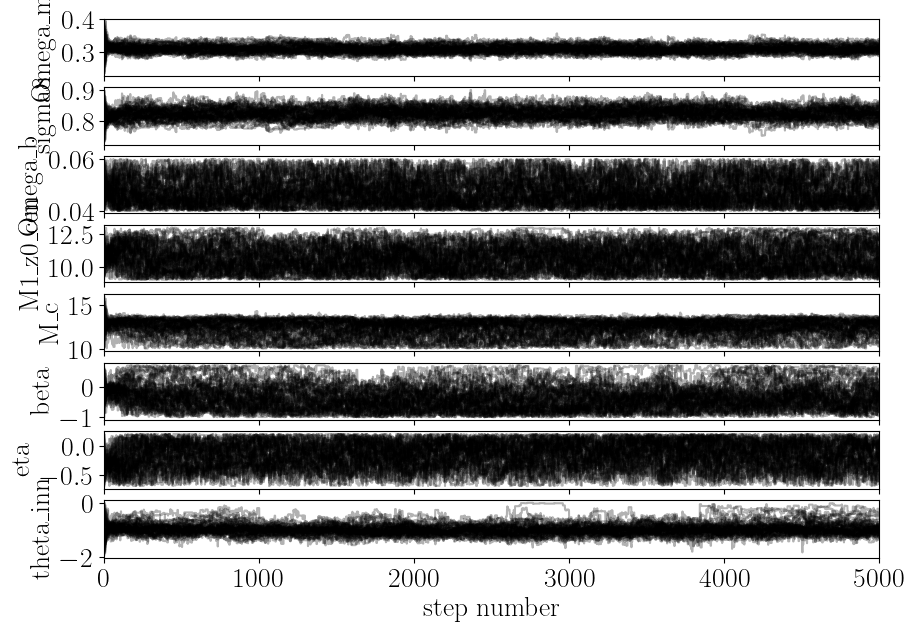

In [166]:
fig, axes = plt.subplots(8, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = para_names_varying
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

[0.3148883745309293, 0.8150245959637266, 0.0500022815806144, 10.999195322491307, 13.003172465302944, -0.1487700739519895, -0.24929430178572687, -1.000002537635119]


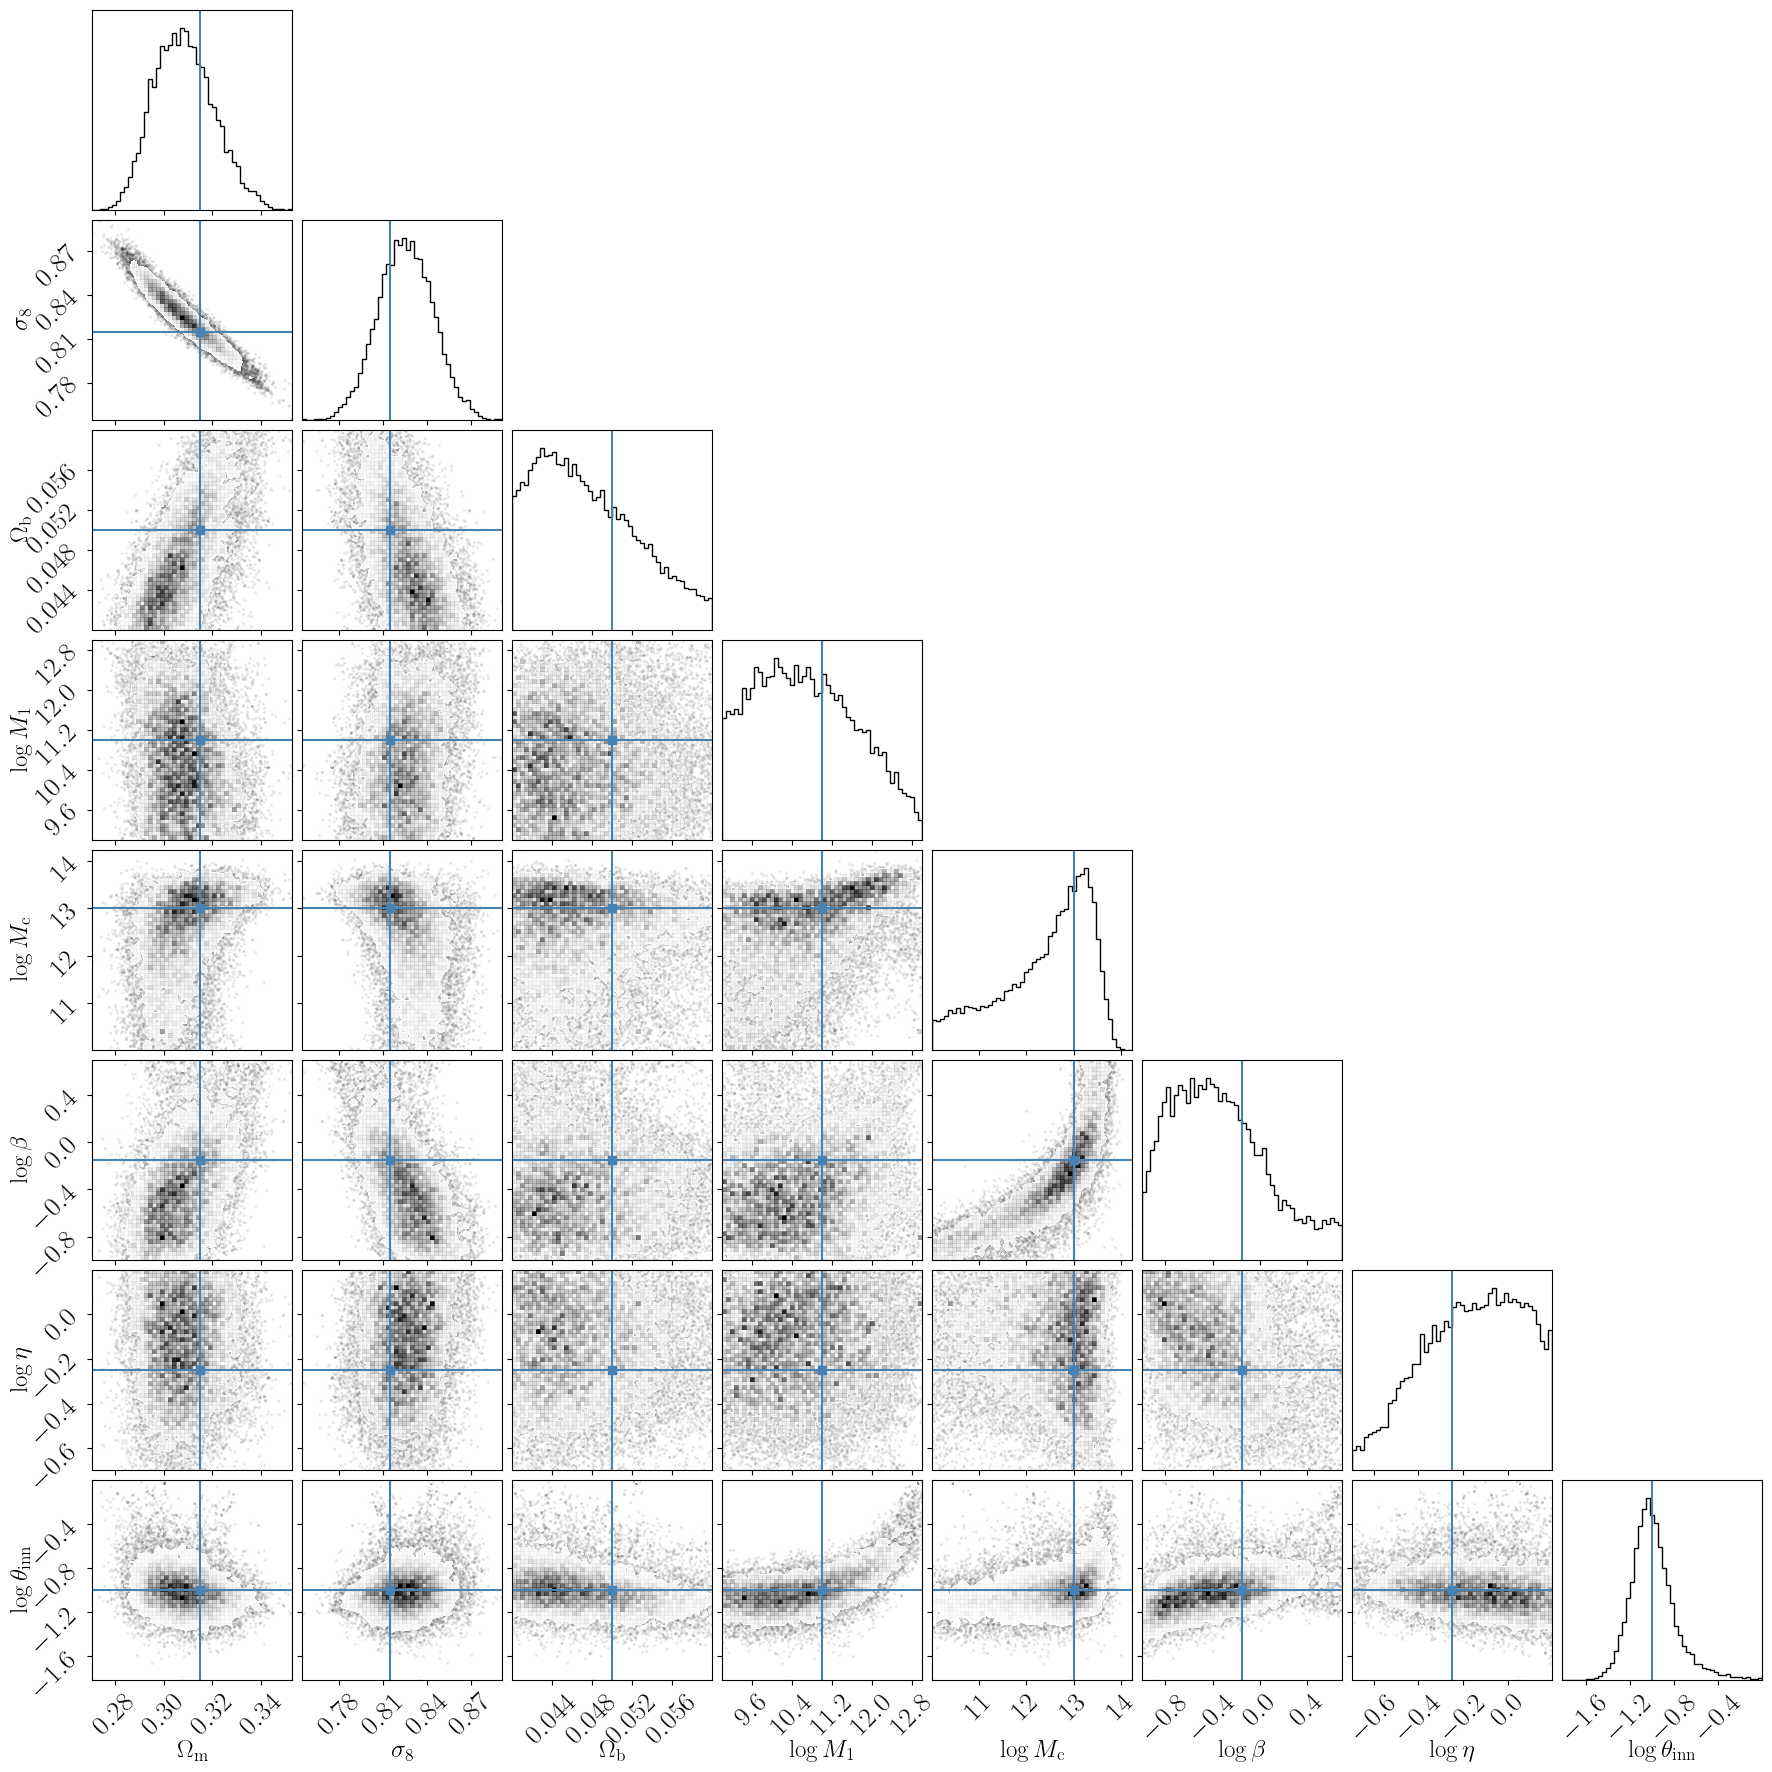

In [162]:
import corner
para_names_latex = [r'$\Omega_\mathrm{m}$', r'$\sigma_8$', r'$\Omega_\mathrm{b}$', r'$\log M_1$', r'$\log M_\mathrm{c}$', r'$\log \beta$', r'$\log \eta$', r'$\log \theta_\mathrm{inn}$']

sample_data = np.load(save_file_path)
para_truth = {name: priors_params[name][1]/2+priors_params[name][0]/2 for name in para_names_varying}
print(list(para_truth.values()))
# Create a corner plot
fig = corner.corner(sample_data["samples"], 
                    labels=para_names_latex, 
                    bins=50, 
                    label_kwargs={"fontsize": 18}, 
                    truths=list(para_truth.values()), 
                    plot_contours=False)

In [163]:
samples_mcmc = np.load(save_file_path)
samples_mcmc["samples"].shape

(16550, 8)

In [165]:
samples_nautilus = np.load('/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/mcmc_samples_Map23_nautilus.npz')
samples, names = samples_nautilus['points'], samples_nautilus['para_names_varying']
samples.shape

(53900, 8)

Removed no burn in
Removed no burn in


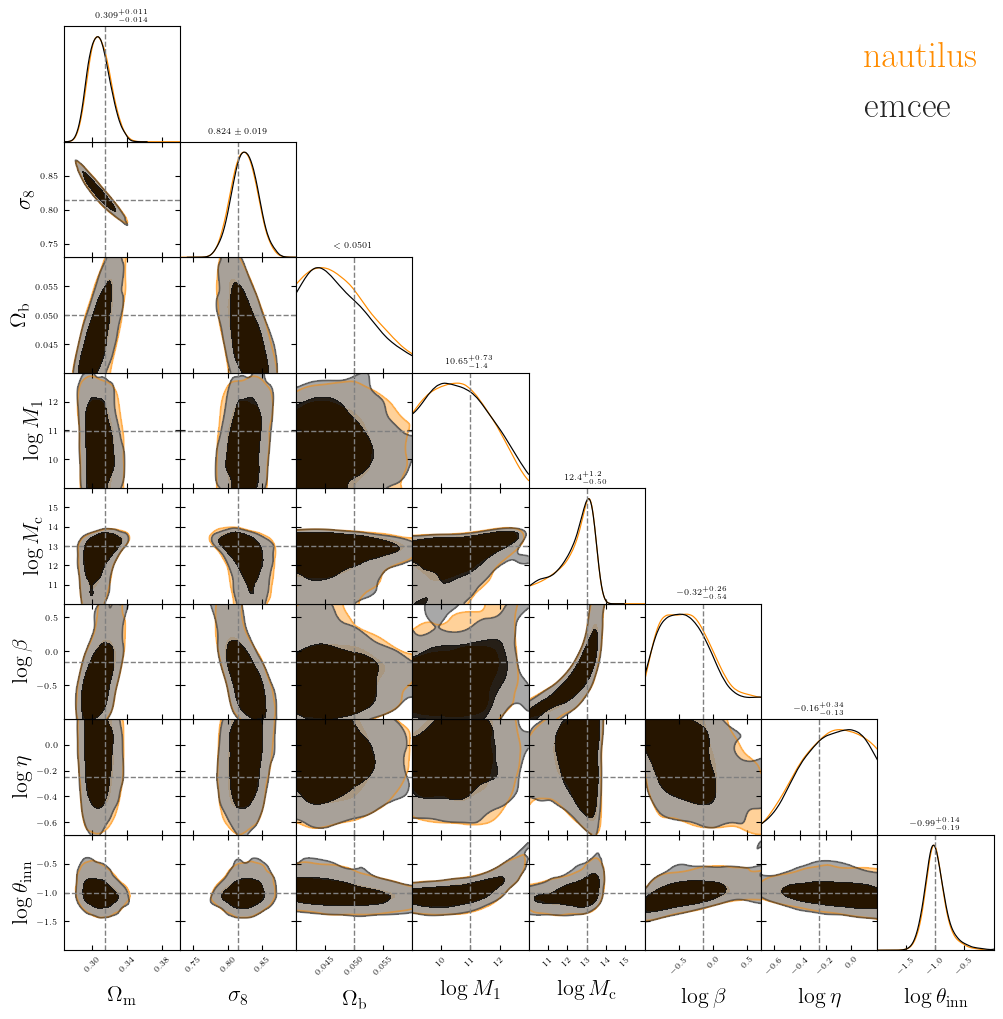

In [167]:
# --- Step 5: Set up GetDist for visualization of parameter inference results ---
from getdist import plots, MCSamples, parampriors
import getdist
import numpy as np

from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)  # Adjust width & height
plt.rcParams["figure.dpi"] = 100  # Lower DPI for smaller display



para_names_latex = [r'$\Omega_\mathrm{m}$', r'$\sigma_8$', r'$\Omega_\mathrm{b}$', r'$\log M_1$', r'$\log M_\mathrm{c}$', r'$\log \beta$', r'$\log \eta$', r'$\log \theta_\mathrm{inn}$']


priors_params = { 
                'M1_z0_cen': [9.000497821926116, 12.997892823056496], 
                'M_c': [10.009180624129629, 15.99716430647626], 
                'beta': [-0.9967784660541272, 0.6992383181501483], 
                'eta': [-0.6977833279473113, 0.1991947243758576], 
                'theta_inn': [-1.9998000600318366, -0.00020501523840121827],
                'Omega_m': [0.23008603805291986, 0.39969071100893877],
                'Omega_b': [0.04000982924130305, 0.059994733919925755],
                'sigma8': [0.7300666536240268, 0.8999825383034264],
            }

para_names = list(priors_params.keys())


if(os.path.exists('/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/mcmc_samples_Map23_HMC_warmup.npy')):
    mcmc_samples = np.load('/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/mcmc_samples_Map23_HMC.npy',allow_pickle=True).item()
    names = ['Omega_m', 'sigma8', 'Omega_b', 'M1_z0_cen', 'M_c', 'beta', 'eta', 'theta_inn']
    samples_HMC = np.array([mcmc_samples[names[0]],mcmc_samples[names[1]],mcmc_samples[names[2]],mcmc_samples[names[3]],mcmc_samples[names[4]],mcmc_samples[names[5]],mcmc_samples[names[6]],mcmc_samples[names[7]]]).T[50_000:]
    samples_HMC = MCSamples(samples=samples_HMC,names = names, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})

samples_nautilus = np.load('/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/mcmc_samples_Map23_nautilus.npz')
samples, names = samples_nautilus['points'], samples_nautilus['para_names_varying']
samples_nautilus = MCSamples(samples=samples,weights= np.exp(samples_nautilus['log_w']),names = names, labels = para_names_latex, ranges = priors_params, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})

samples_mcmc = np.load(save_file_path)
samples, names = samples_mcmc['samples'], samples_mcmc['para_names_varying']
samples_mcmc = MCSamples(samples=samples,names = names, labels = para_names_latex, 
                         ranges = priors_params, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})

para_truth = {name: priors_params[name][1]/2+priors_params[name][0]/2 for name in para_names_varying}


colors = ['black','C2','C0']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['darkorange', 'blue', 'green','darkorange']

# retro = ['black','#e770a2','#4165c0','#5ac3be', '#696969', '#f79a1e', '#ba7dcd']


g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
# g.settings.axis_marker_ls = '-' 
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'grey'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 30
g.settings.axes_fontsize = 10
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()

contour_colors = ['darkorange', 'black'] 

if(os.path.exists('/home/aramasub/MCMC_project/sampler_comparison-main/sampler_comparison-main/outputs/mcmc_samples_Map23_HMC_warmup.npy')):
    g.triangle_plot(
        roots=[samples_nautilus, samples_HMC, samples_mcmc],
        filled=[True, False],
        contour_colors=contour_colors,
        legend_loc='upper right',
        legend_labels = ['nautilus','HMC'],
        title_limit=1,
        markers=para_truth,
    )
else:
    g.triangle_plot(
        roots=[samples_nautilus, samples_mcmc],
        filled=[True, True],
        contour_colors=contour_colors,
        legend_loc='upper right',
        legend_labels = ['nautilus', 'emcee'],
        title_limit=1,
        markers=para_truth,
    )


